<a href="https://colab.research.google.com/github/saurabh-jain/registration/blob/master/evolution_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 
# **Un modèle semi-empirique simple**

Conclusion partielle au 26 Mars:

1.   Italie: Le modèle prévoit dpeuis une semaine un pic autour du 1 Avril avec 1000 m/j. ON peut espérer que cela soit un peu pessimiste et que nous soyons déjà au pic. Un nombre total de décès prédit au dela de la dizaine de millier. 
2.   France: Malheureusement, on ne voit pas vraiment d'éffet clair du confinement pour la France et on s'éloigne de la trajectoire italienne. La situation est très préoccupante. Pas de pic en vue dans les données ou très lointain.
3.   Espagne: Situation sans doute encore pus critique que la situation de la
France.



## To do


*   Problème de bruit sur les données à résoudre: (Fait, traiter par un modèle probailiste)
*   Tester le modèle sur les données dont on dispose dans les series de JHU (Fait)
*   Utiliser les series longues existantes pour tester les methodes de reguarisation par validation.
*   Regarder les problèmes de calibration en utilisant les approches séquentielles de minimisation du regret (Inutile)
*   Mettre en place la production d'intervalle de confiances
*   Regarder l'applicabilité du modèle sur les données de cas déclarés



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import urllib.request
import scipy as sp
from matplotlib import cm
import torch
import time

from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime # for dates

# Les modèles



## Modèle "Zombie" déterministe (Mod A)

Le modèle d'évolution du nombre de cas est juste un modèle du type logistique
couplant deux equations, l'une pour le nombre de mort $t\to m(t)$ et l'autre 
pour l'évolution du taux d'accroissement $\alpha$ journalier du nombre de morts

$$\left\{\begin{array}{rcl}
\dot{m} & = & \alpha m \\
\dot{\alpha} &= &-\rho\alpha
\end{array}\right.$$

On suppose ici que $\rho$ est constant en temps (est-ce que cela à un sens ?)
à estimer sur les données. Je suis parti plutôt de l'inverse en remarquant 
une certaine constance de $\rho$ sur les données.

La solution est donnée par 
$$\left\{
\begin{array}{rcl}
\alpha(t) & = & \alpha(t_0)\exp(-\rho(t-t_0))\\
& &\\
m(t)&= & m(t_0)\exp(\frac{\alpha(t_0)}{\rho}(1-\exp(-\rho(t-t_0))
\end{array}\right.$$

Dans l'implémentation actuelle, nous comme paramètre $\theta=(m_0,\alpha_0,\rho)$ et implicitement $t_0$ qui est fixé à la main. On suppose que les données observées sont i.i.d et que $\mathbf{m}_i\sim\mathcal{P}(m(t_i))$ pour $i=0,\cdot,n-1$ (modèle de bruit Poissonien). L'estimation est faite par max de vraisemblance par un algorithme L-BFGS 

## Modèle "Zombie"  Bayesien Poissonien (Mod B)

 Je décris ici un équivalent stochastique du mmodèle déterministe dans un cadre Bayesien pour pouvoir généer des barres d'erreur per exemple

 Le modèlle est très simple en temps discret de paramètre $\theta=(\alpha_0,\rho)$ avec

 $$\left|\begin{array}{l}X_{i+i}|X_i \sim \mathcal{P}(\alpha_i X_i)\\
 \alpha_{i+1}=(1-\rho)\alpha_i\end{array}\right.$$

 initialisé avec $X_0=x_0$. On prend pour loi a priori $\theta\sim \text{Unif}([\alpha_{min},\alpha_{max}]\times[\rho_{min},\rho_{max}])$

 Etant donné $X_0^{N-1}$, on calcule la loi a *posteriori* de $\theta$ sachant $X_0^N$ et des quantités intéressantes sur la loi de  $X_N^{N+p}$ sachant $X_0^{N-1}$ où $p$ est l'horizon comme des intervalle de confiance sur les valeur de $X$, le temps d'atteinte du pic ou la hauteur du pic.

**A faire:** Introduire un test de positivité signe de $\rho$ en fonction de la la loi a posteriori de $\rho$ sachant $X_0^N$ permettant d'annuler le calcul du temps d'atteinte du pics en cas de rejet.


# Fonctions utiles pour le modèle
Je regroupe ici mes fonctions de vizu et de prediction correspondant au modèle.
A sauter lors d'une première visit et se rendre directement au cas de Hubei (section suivante)

In [0]:
def show_data(mj,pays='France', label='morts'):
  nb_j = np.shape(mj)[0] # nb points de donnée

  # cumul du nombre de morts
  m = np.cumsum(mj)
  t = np.arange(nb_j) # temps en jours

  plt.rcParams["figure.figsize"] = (16, 4) # (w, h)
  plt.subplot(131)
  plt.bar(t,mj,0.5)
  plt.title('Nombre de ' + label +' journalier (' + pays +')')
  plt.grid()

  plt.subplot(132)
  plt.bar(t,m,0.5)
  plt.title('Nombre de ' + label + ' cumulés (' + pays + ')')
  plt.grid()

  plt.subplot(133)
  plt.semilogy(t,m)
  plt.title('Idem en échelle log (' + pays + ')')
  plt.grid()

def fit_slope(mj, start=10, label = 'morts'):
  # cumul du nombre de morts
  m = np.cumsum(mj)
  t = np.arange(np.shape(mj)[0]) # temps en jours

  plt.figure()
  Dotm = mj[1::]/m[0:-1]
  plt.title('Estim. taux accroissement du nb de ' + label + '(echelle log)')                
  reg = stats.linregress(t[start:-1], np.log(Dotm[start::]))
  plt.semilogy(t[start:-1],np.exp(reg[0]*t[start:-1]+reg[1]))
  plt.semilogy(t[0:-1],Dotm)
  plt.grid(which='minor')
  plt.show()
  print('rho estimé',-reg[0])
  return reg

def predic(mj, reg, start = 10, end = 90, label = 'morts'):
  # cumul du nombre de morts
  m = np.cumsum(mj)
  nb_j = np.shape(mj)[0]
  t = np.arange(nb_j) # temps en jours
  slope, intercept = reg[0], reg[1]
  rho = - slope
  m0 = m[start]
  alpha0=np.exp(slope*t[start]+intercept)
  prev_t = np.arange(start,end)
  hm = m0*np.exp(alpha0*(1-np.exp(-rho*(prev_t-t[start])))/rho)
  plt.rcParams["figure.figsize"] = (16, 4) # (w, h)
  plt.subplot(121)
  plt.title('Prevision nb ' + label + ' cumulés (échelle log)')
  plt.semilogy(prev_t,hm)
  plt.semilogy(t[start::],m[start::])
  plt.subplot(122)
  plt.title('Prevision nb ' + label +  ' par jour')
  plt.plot(prev_t[0:-1],hm[1::]-hm[0:-1])
  plt.plot(t[start:-1],mj[start+1::])
  plt.grid()
  plt.show()

def RalstonIntegrator():
  def subf1(x,xdot,dt):
    return tuple(map(lambda x,xdot: x + (2 * dt/3) * xdot, x, xdot))

  def subf2(x,xdot,xdoti,dt):
    return tuple(map(lambda x, xdot, xdoti: 
            x + (.25 * dt) * (xdot + 3 * xdoti), x, xdot, xdoti))
        
  def f(ODESystem, x0, nt, deltat=1.0):  
    x = tuple(map(lambda x: x.clone(),x0))
    dt = deltat / nt
    l = [x]
    for i in range(nt):
      xdot = ODESystem(*x)
      xi = subf1(x,xdot,dt)
      # xi = tuple(map(lambda x, xdot: x + (2 * dt / 3) * xdot, x, xdot))
      xdoti = ODESystem(*xi)
      x = subf2(x,xdot,xdoti,dt)
      # x = tuple(map(lambda x, xdot,
      #  ....xdoti: x + (.25 * dt) * (xdot + 3 * xdoti), x, xdot, xdoti))
      l.append(x)
    return l  
  return f

def ZombieSystem(param):
    (m0,alpha0,rho)= param
    def F(m, alpha):
        return (alpha*m, -rho*alpha)
    return F

def ll(param, data):
    deltat = len(data) -1# Durée de simulation
    K = 10 # nb pas temporel par jour
    nt =K*deltat # nb de pas temporel
    x0 = param[0:2] # Données initiales
    l=Shooting(x0, param, nt=nt, 
               deltat = deltat, Integrator=RalstonIntegrator())
    out = torch.zeros((1,), requires_grad = True)
    n = len(data)
    for i in range(n):
        out = out - (data[i]*l[i*K][0].log()-l[i*K][0])
    return out
    
def Shooting(x0, param, nt=20, deltat = 10., Integrator=RalstonIntegrator()):
    return Integrator(ZombieSystem(param), x0, nt, deltat=deltat)

def fit_zombie(ndata, param_init = [10., 0., 0.], lr = 0.05, 
               niter = 2000, verbose = False, Adam = False):
    data = torch.from_numpy(ndata)
    param = torch.tensor(param_init, requires_grad = True)
    optimizer = torch.optim.LBFGS([param], lr, max_iter=20, max_eval=None, 
                  tolerance_grad=1e-07, tolerance_change=1e-09, 
                  history_size=100, line_search_fn=None)
    if Adam:
      optimizer = torch.optim.Adam([param], lr)
    print('performing optimization...')
    start = time.time()

    lL=[]
    def closure():
        optimizer.zero_grad()
        L = ll(param, data)
        if verbose:
            print('log likelihood', L.detach().cpu().numpy())
        L.backward()
        if verbose:
            print(param)
        lL.append(-L)
        return L

    for i in range(niter):
        if verbose:
            print('it ', i, ': ', end='')
        optimizer.step(closure)
    
    print('Optimization (L-BFGS) time: ', round(time.time() - start, 2), 
              ' seconds')
    plt.figure()
    plt.plot(lL,'k-')
    plt.title('Evolution log vraisemblance')
    plt.show()
    
    return param


def disp_fit(param, m, horizon, start = start, label = 'morts', 
             date1 = datetime.date(2020, 2, 21)):
  
    data = torch.from_numpy(m)
    deltat = len(data) -start + horizon -1 # Durée de simulation

    date2 = date1 + datetime.timedelta(days=start)
    date3 = date2 + datetime.timedelta(days=deltat+1)
    delta = datetime.timedelta(days=1)
    dates = drange(date2, date3, delta)
    print(len(dates))
    
    K = 10 # nb pas temporel par jour
    nt =K*deltat # nb de pas temporel
    l=Shooting(param[0:2], param, nt=nt, deltat = deltat,
               Integrator=RalstonIntegrator())
    tl = tuple(map(lambda x: x[0],l))
    stl = tl[0::K]
    plt.rcParams["figure.figsize"] = (16, 4) # (w, h)

    ax = plt.subplot(121, yscale='log')
    plt.title('Prevision nb ' + label + ' cumulés (échelle log)')
    plt.plot_date(dates,stl,'-')
    date2a = date2
    date2b = date2a + datetime.timedelta(days=len(data)- start)
    plt.plot_date(drange(date2a, date2b, delta), data[start::],'o-')
    ax.xaxis.set_tick_params(rotation=30, labelsize=8)
    plt.grid()
    #plt.semilogy(np.arange(len(data)), data)

    ax = plt.subplot(122)
    plt.title('Prevision nb ' + label +  ' par jour')
    dtl = tuple(map(lambda i: stl[i+1]-stl[i], range(len(stl)-1)))
    #plt.plot_date(dates, data[1::]-data[0:-1], 'mo')
    date2a = date2 + delta
    date2b = date2a + datetime.timedelta(days=len(data)- start-1)
    plt.plot_date(drange(date2a, date2b, delta), 
                  data[start+1::]-data[start:-1], 'mo-')
    date2b = date2a + datetime.timedelta(days=deltat)
    plt.plot_date(drange(date2a, date2b, delta), dtl, 'b-')
    ax.xaxis.set_tick_params(rotation=30, labelsize=8)
    plt.grid()
    plt.show()
    
def predic_data(param, mj, horizon):
    data = torch.from_numpy(np.cumsum(mj))
    deltat = len(data) -1 + horizon# Durée de simulation
    K = 10 # nb pas temporel par jour
    nt =K*deltat # nb de pas temporel
    l=Shooting(param[0:2], param, nt=nt, deltat = deltat,
               Integrator=RalstonIntegrator())
    tl = tuple(map(lambda x: x[0],l))
    stl = tl[0::K]
    dtl = tuple(map(lambda i: stl[i+1]-stl[i], range(len(stl)-1)))
    plt.figure()
    plt.plot(np.arange(len(data)-1), data[1::]-data[0:-1], 'mo')
    plt.plot(np.arange(len(dtl)), dtl, 'b-')
    plt.show()

def simulate(theta,x0, N):
    alpha0, rho = theta
    x = np.zeros(N)
    x[0]=x0
    alpha = (1+alpha0)
    for i in range(N-1):
        x[i+1] = np.random.poisson(lam = alpha*x[i])
        alpha = (1-rho)*alpha
    return x

def lv(x,theta):
    alpha0, rho = theta
    f = 0
    for i in range(len(x)-1):
        f += x[i+1]*(i*np.log(1-rho)+np.log(alpha0))-(1-rho)**i*alpha0*x[i]
    return f

def sample_theta_post(eF, alpha0, rho):
    # Simulate an M sample from distribution F
    pk = eF
    pk = pk/sum(pk)
    vk = np.arange(len(pk))
    sampler = sp.stats.rv_discrete(name='custm', values=(vk, pk))
    def f(M):
        sind = sampler.rvs(size=M)
        salpha0 = alpha0[sind]
        srho = rho[sind]
        return (salpha0, srho)
    return f

def sample_x_post(sampler_theta_post,x0, start, M, n_hor):
    z = np.zeros((M,n_hor+1))
    salpha0, srho = sampler_theta_post(M)
    salpha0 = (1+salpha0)*(1-srho)**start -1
    for i in range(M):
        z[i,:] = simulate((salpha0[i], srho[i]) ,x0,n_hor+1)
    return z
    
def par_estim(x,start):
    na, nr = (300, 300)
    rect = [0.01, 2, -0.15, 0.15]
    amin, amax, rmin, rmax = rect
    alpha0, rho = np.meshgrid(np.linspace(amin,amax,na), 
                              np.linspace(rmin,rmax,nr))
    F = lv(x[0:start+1],(1+alpha0, rho))
    ind = np.unravel_index(np.argmax(F, axis=None), F.shape)
    F = F-F[ind]
    eF = np.exp(F)
    plt.rcParams["figure.figsize"] = (10, 6)
    fig = plt.figure()


    ax = fig.gca()
    acF = ax.contour(alpha0, rho, eF, 4, cmap= 'coolwarm')
    #ax.imshow(np.flipud(eF), cmap='coolwarm', extent = [0.01, 2, 0.01, 2])
    #cset = ax.contour(alpha0, rho, eF, colors='k')
    ax.clabel(acF, inline=1, fontsize=10)
    plt.ylabel('rho')
    plt.xlabel('alpha')
    plt.title('Posterior density')
    sampler = sample_theta_post(eF.flatten(),alpha0.flatten(), rho.flatten())
    (salpha0, srho) = sampler(100)
    ax.plot(salpha0,srho,'b.')
    plt.show()
    print("alpha0 = {:.2f}".format(alpha0[ind]))
    print("rho    = {:.2f}".format(rho[ind]))
    return sampler

def bayes_pred(sampler, x0, start, M, n_hor):
    z = sample_x_post(sampler,x0, start, M, n_hor)
    plt.rcParams["figure.figsize"] = (10, 4)
    ins = np.argmax(z, axis=1)
    #inst = np.argmax(x)-start
    plt.subplot(121)
    plt.boxplot(ins)
    #plt.plot(1,inst,'ro')
    plt.title('Estimation temps atteinte du pic')
    plt.subplot(122)
    plt.boxplot(np.log(np.max(z,axis =1))/np.log(10))
    #plt.plot(1,np.log(np.max(x))/np.log(10),'ro')
    plt.title('Hauteur du pic (echelle log (base 10)')
    plt.show()
    plt.boxplot(z[:,0:4], labels = (0,1,2,3))
    plt.title('prevision à 3 jours')
    plt.show()
    return

def load_csse(CountryName):
  covid = pd.read_csv("/content/drive/My Drive/Covid19/time_series_covid19_deaths_global.csv")
  state = covid[covid["Country/Region"]==CountryName]
  return state

def load_csse_confirmed(CountryName):
  covid = pd.read_csv("/content/drive/My Drive/Covid19/time_series_19-covid-Confirmed.csv")
  state = covid[covid["Country/Region"]==CountryName]
  return state

Même si ce n'est pas dans cet ordre que j'ai fait les choses, le plus parlant est de commencer par le cas de Hubei

Le cas de l'italie selon  les [données sur wikipedia](https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_maladie_%C3%A0_coronavirus_de_2020_en_Italie#Statistiques)
et [le cas de la France](https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_maladie_%C3%A0_coronavirus_(COVID-19)_de_2020_en_France). Finalement toutes les données son mise à dispo par JHU dans un [git ici](https://github.com/CSSEGISandData/COVID-19).

# Hubei
Changement des données JHU 

In [0]:
covid = pd.read_csv("/content/drive/My Drive/Covid19/time_series_19-covid-Deaths.csv")
prov = covid["Province/State"]
prov.shape
hubei = covid[covid["Province/State"]=="Hubei"]
hubei.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
154,Hubei,China,30.9756,112.2707,17,17,24,40,52,76,125,125,162,204,249,350,414,479,549,618,699,780,871,974,1068,1068,1310,1457,1596,1696,1789,1921,2029,2144,2144,2346,2346,2495,2563,2615,2641,2682,2727,2761,2803,2835,2871,2902,2931,2959,2986,3008,3024,3046,3056,3062,3075,3085,3099,3111,3122


On affiche les données pour la province de Hubei

[17 17 24 40 52 76 125 125 162 204 249 350 414 479 549 618 699 780 871 974
 1068 1068 1310 1457 1596 1696 1789 1921 2029 2144 2144 2346 2346 2495
 2563 2615 2641 2682 2727 2761 2803 2835 2871 2902 2931 2959 2986 3008
 3024 3046 3056 3062 3075 3085 3099 3111 3122]
[ 17.   0.   7.  16.  12.  24.  49.   0.  37.  42.  45. 101.  64.  65.
  70.  69.  81.  81.  91. 103.  94.   0. 242. 147. 139. 100.  93. 132.
 108. 115.   0. 202.   0. 149.  68.  52.  26.  41.  45.  34.  42.  32.
  36.  31.  29.  28.  27.  22.  16.  22.  10.   6.  13.  10.  14.  12.
  11.]


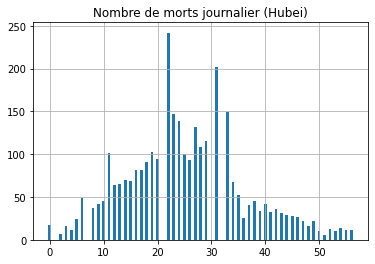

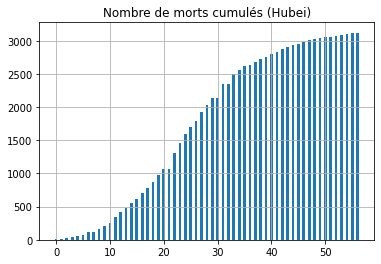

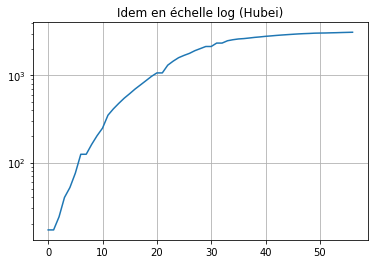

In [0]:
m=hubei.iloc[0,4::].to_numpy()
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]

print(mj)

# cumul du nombre de morts
m = np.cumsum(mj)
t = np.arange(nb_j) # temps en jours

plt.figure()
plt.bar(t,mj,0.5)
plt.title('Nombre de morts journalier (Hubei)')
plt.grid()

plt.figure()
plt.bar(t,m,0.5)
plt.title('Nombre de morts cumulés (Hubei)')
plt.grid()

plt.figure()
plt.semilogy(t,m)
plt.title('Idem en échelle log (Hubei)')
plt.grid()


On affiche en suite l'estimation des taux d'acroissement ainsi qu'une régression linéaire. On voit très bien la tendance linéaire à la décroissance dans une échelle logarithmique dans les données (en orange). On estime alors les paramètre de la droite sur la dernière partie de la course plus stable (en bleu). J'ai fait un petit lissage sur trois jours des données de mortalité journalières.

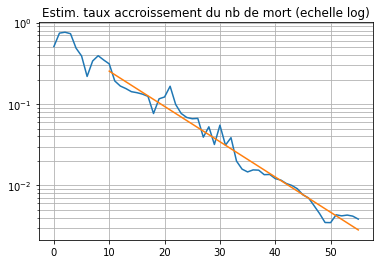

rho estimé:  0.09985285926610947


In [0]:
plt.figure()
# Régularisation du nombre de morts journaliers
rmj = np.zeros(np.shape(mj))
rmj = mj
rmj[0:-2]= (mj[0:-2]+mj[1:-1]+mj[2::])/3
Dotm = (rmj[1::]+1)/m[0:-1]
plt.title('Estim. taux accroissement du nb de mort (echelle log)')
start = 10
slope, intercept, r_value, p_value, std_err = stats.linregress(t[start:-1],np.log(Dotm[start::]))
plt.semilogy(t[0:-1],Dotm)
plt.semilogy(t[start:-1],np.exp(slope*t[start:-1]+intercept))
plt.grid(which='both')
plt.show()
rho = -slope
print('rho estimé: ',rho)



La pente estime la valeur de $-\rho$. On peut mettre en place le modele en partant d'un $t_0$ en affichant en bleu les données prédicte par le modèle et en orange les données réelles pour le nombre de morts cumulés et journalier.

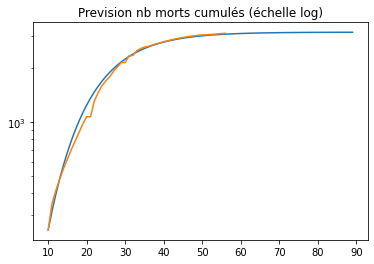

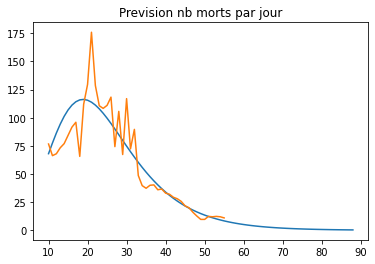

In [0]:
end=90
m0 = m[start]
tau0=np.exp(slope*t[start]+intercept)

prev_t = np.arange(start,end)
hm = m0*np.exp(tau0*(1-np.exp(-rho*(prev_t-t[start])))/rho)
plt.figure()
plt.title('Prevision nb morts cumulés (échelle log)')
plt.semilogy(prev_t,hm)
plt.semilogy(t[start::],m[start::])
fig = plt.figure()
plt.title('Prevision nb morts par jour')
plt.plot(prev_t[0:-1],hm[1::]-hm[0:-1])
plt.plot(t[start:-1],mj[start+1::])

# Italie
On essaie maintenant sur l'Italie (j'ai en fait commencé par là)

## Au 17 Mars

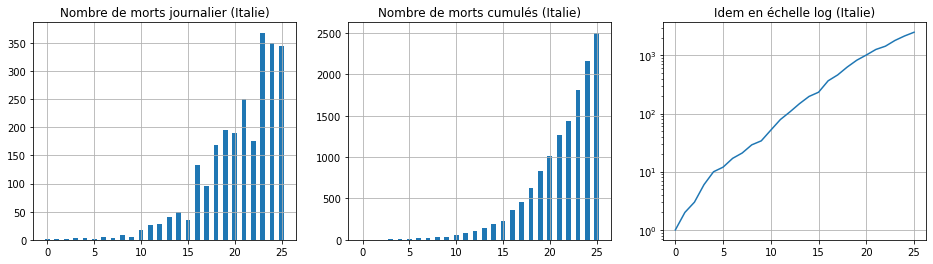

In [0]:
# Morts journaliers du covid19 italie
mj = np.array([1,1,1,3,4,2,5,4,8,5,18,27,28,41,49,36,133,
               96,169,196,189,250,175,368,349, 345])
show_data(mj,'Italie')

On affiche en suite l'estimation des taux d'acroissement ainsi qu'une régression linéaire.
On voit bien la tendance linéaire à la décroissance dans une échelle logarithmique dans les données (en orange), évidemment avec du bruit surtout dans les premiers jours où lles effets stochastiques sont très présents. On estime alors les paramètre de la droite sur la dernière partie de la course plus stable (en bleu)

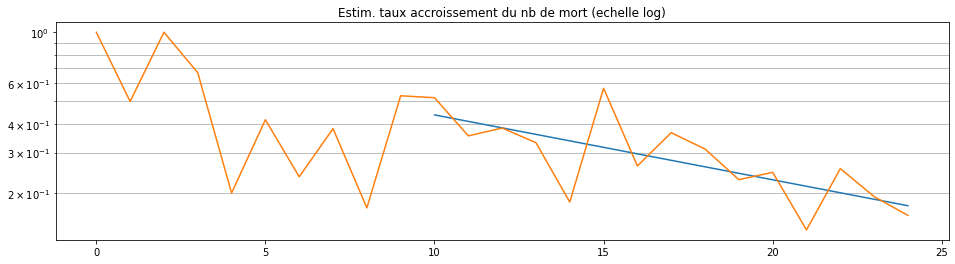

rho estimé 0.06495286090124061


In [0]:
reg = fit_slope(mj, start = 10)

La pente estime la valeur de $-\rho$. On peut mettre en place le modele en partant d'un $t_0$ en affichant en bleu les données prédicte par le modèle et en orange les données réelles pour le nombre de morts cumulés et journalier.

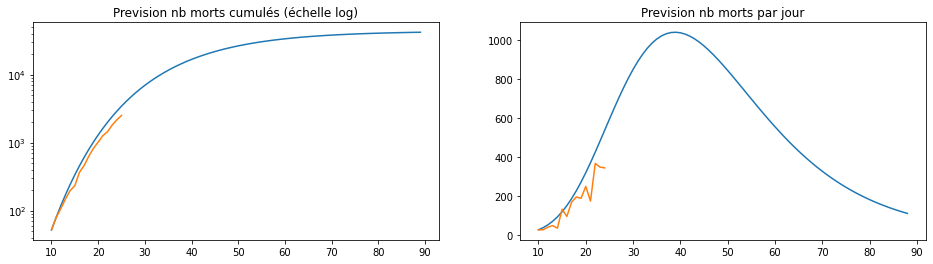

In [0]:
predic(mj, reg, start = 10, end = 90)

## Au 18 Mars

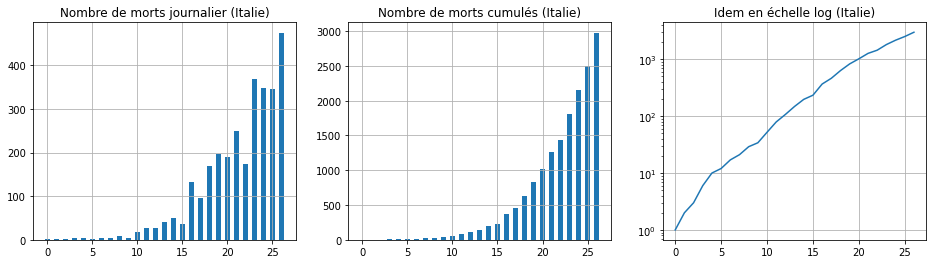

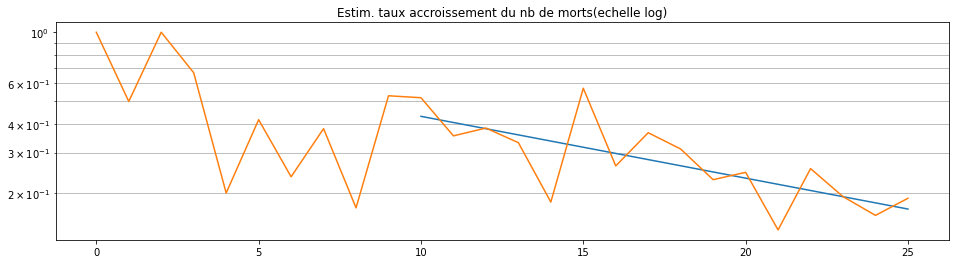

rho estimé 0.06186886304634119


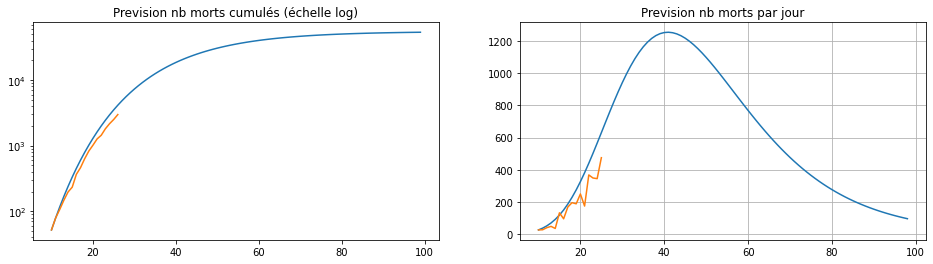

In [0]:
# Morts journaliers du covid19 italie
mj = np.array([1,1,1,3,4,2,5,4,8,5,18,27,28,41,49,36,133,
               96,169,196,189,250,175,368,349, 345,475])
show_data(mj,'Italie')
reg = fit_slope(mj, start = 10)
predic(mj, reg, start = 10, end = 100)

## 19 Mars

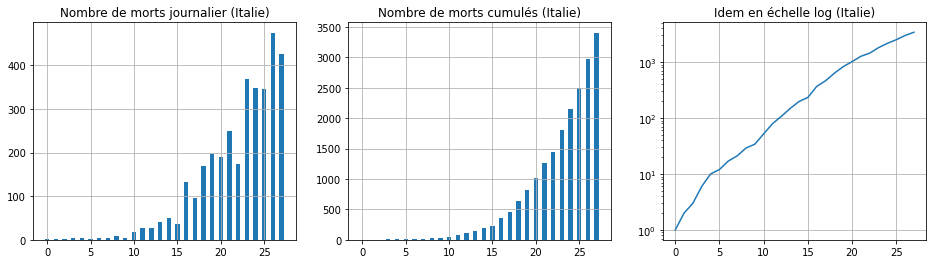

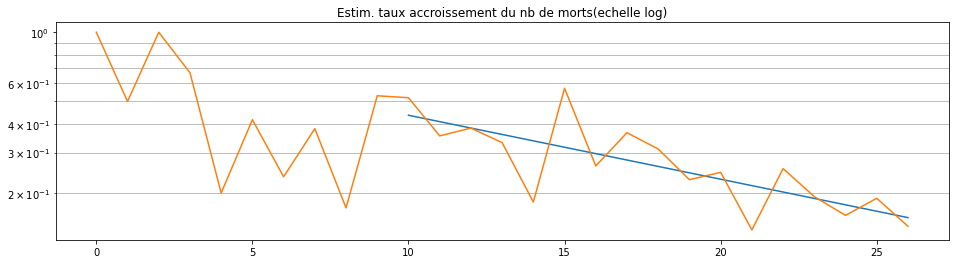

rho estimé 0.06403521451007403


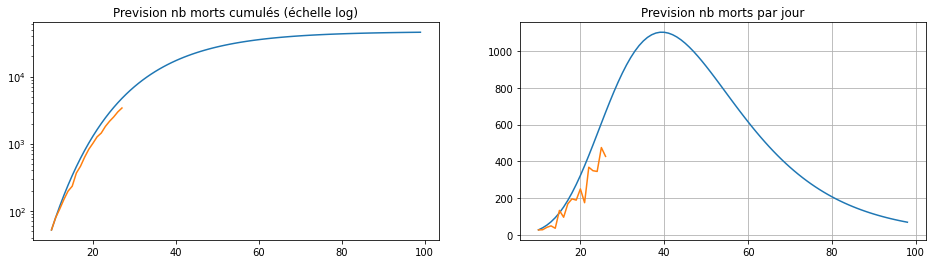

In [0]:

# Morts journaliers du covid19 italie
mj = np.array([1,1,1,3,4,2,5,4,8,5,18,27,28,41,49,36,133,
               96,169,196,189,250,175,368,349, 345,475, 427])
show_data(mj,'Italie')
reg = fit_slope(mj, start = 10)
predic(mj, reg, start = 10, end = 100)

Remarque: La prédiction semble assez stable pour l'Italie avec un pic attendu à la fin du mois avec 1000 m/j

## Le 20 Mars

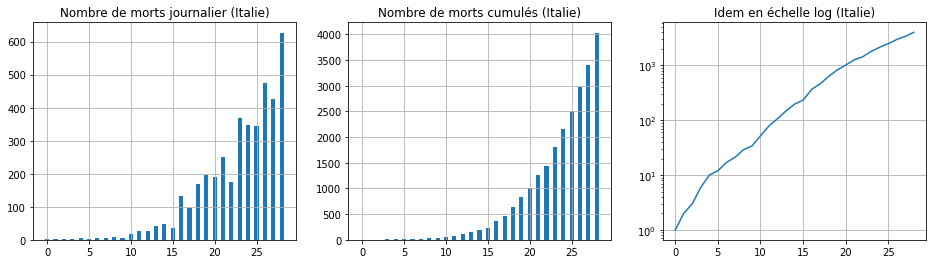

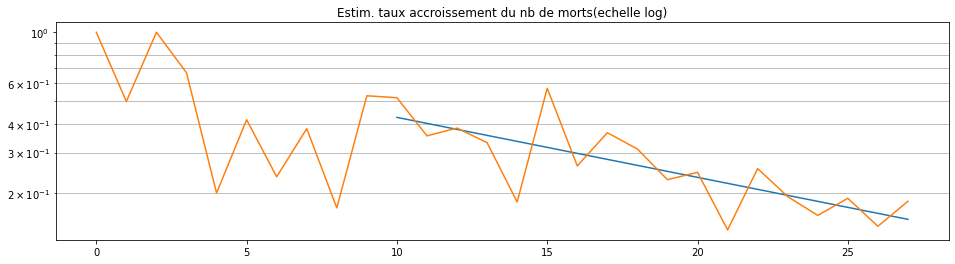

rho estimé 0.06004309735173373


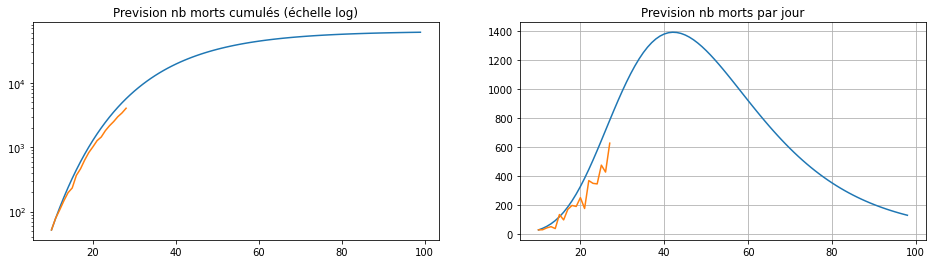

In [0]:
# Morts journaliers du covid19 italie
mj = np.array([1,1,1,3,4,2,5,4,8,5,18,27,28,41,49,36,133,
               96,169,196,189,250,175,368,349, 345,475, 427, 627])
show_data(mj,'Italie')
reg = fit_slope(mj, start = 10)
predic(mj, reg, start = 10, end = 100)

## 26 Mars

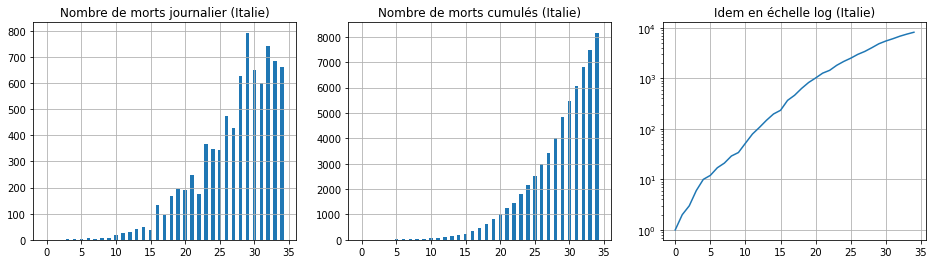

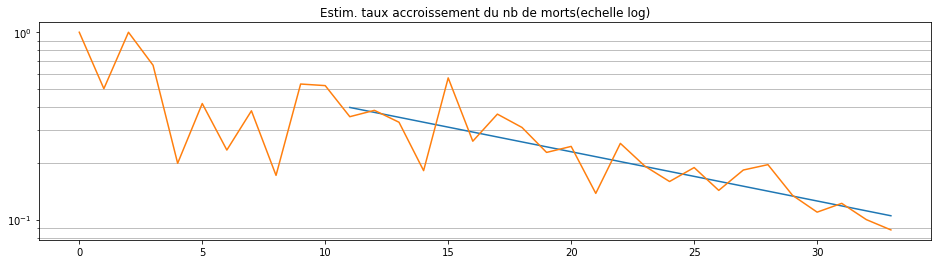

rho estimé 0.0604682500576446
performing optimization...
Optimization (L-BFGS) time:  25.27  seconds


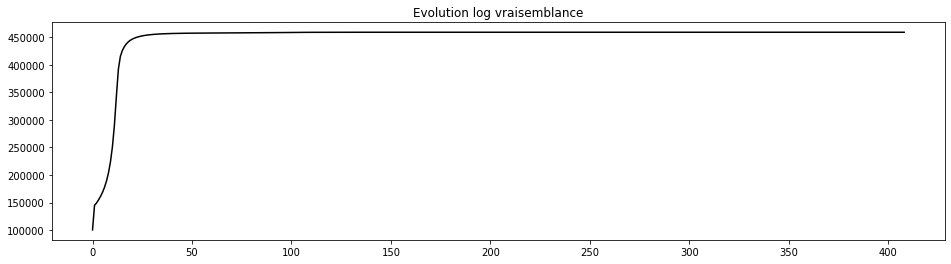

In [0]:
# Morts journaliers du covid19 italie
mj = np.array([1,1,1,3,4,2,5,4,8,5,18,27,28,41,49,36,133, 96,169,196,189,250,175,368,349, 345,475, 427, 627, 793, 651, 601, 743, 683, 662])
show_data(mj,'Italie')
start =11
reg = fit_slope(mj, start = start)
#predic(mj, reg, start = start, end = 100)
m = np.cumsum(mj)
param_init = [m[start], reg[1], -reg[0]]
param = fit_zombie(m[start::], param_init = param_init, niter = 100, 
                   lr = 0.05, verbose = False)

tensor([7.9001e+01, 3.5487e-01, 5.4247e-02], requires_grad=True)
84


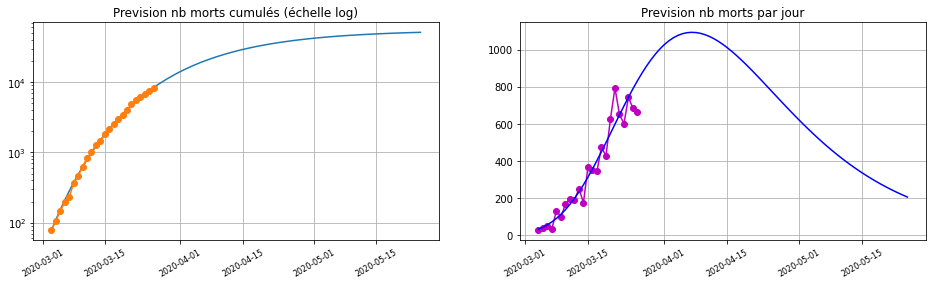

In [0]:
print(param)
date1 = datetime.date(2020, 2, 21)
disp_fit(param, m,60, start = start, date1 = date1)

## Modele Bayesien (Mod B)

## Le 25 Mars

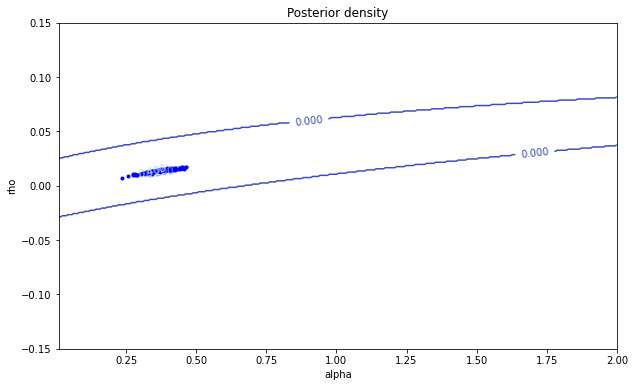

alpha0 = 0.37
rho    = 0.01


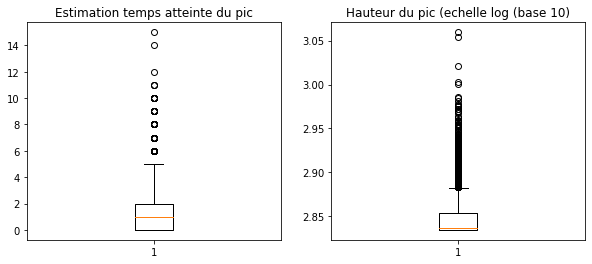

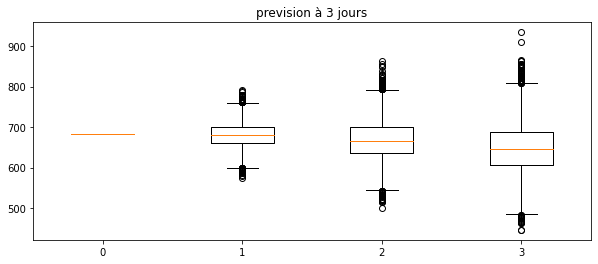

In [0]:
mj=np.array([18,27,28,41,49,36,133,
               96,169,196,189,250,175,368,349, 345, 475, 427, 627,793, 651, 601, 743, 683])
start = len(mj)-1
M, n_hor = 10000, 30
sampler = par_estim(mj,start)
bayes_pred(sampler, mj[start], start, M, n_hor)


# France

## Le 26 Mars

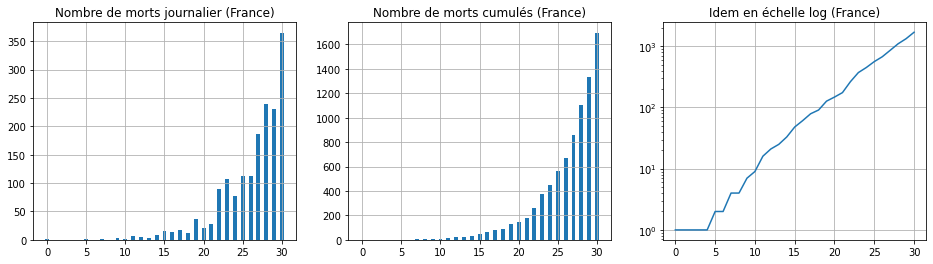

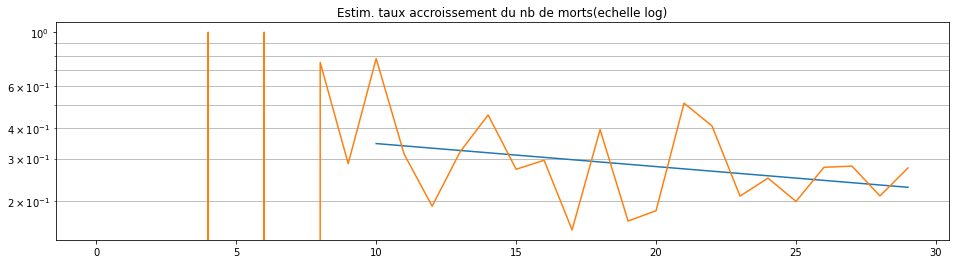

rho estimé 0.021937482327545884
performing optimization...
Optimization (L-BFGS) time:  23.7  seconds


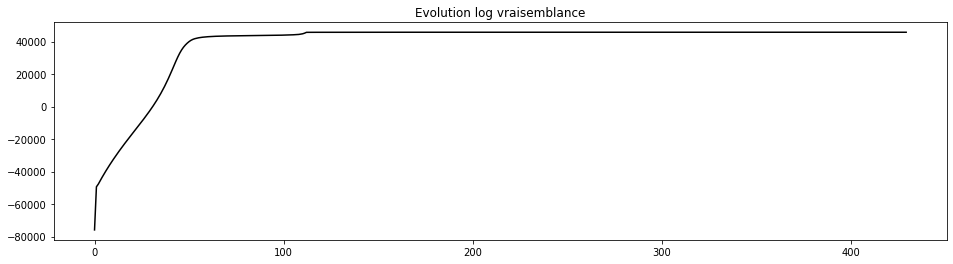

In [0]:
mj = np.array([1,0,0,0,0,1,0,2,0,3,2,7,5,4,8,15,13,18,12,36, 21, 27, 89, 108, 78, 112, 112, 186, 240, 231, 365])
show_data(mj,'France')
start = 10
reg = fit_slope(mj, start = start)
m = np.cumsum(mj)
param_init = [m[start], reg[1], -reg[0]]
param = fit_zombie(m[start::], param_init = param_init, niter = 100)

tensor([9.0023, 0.3199, 0.0209], requires_grad=True)
36


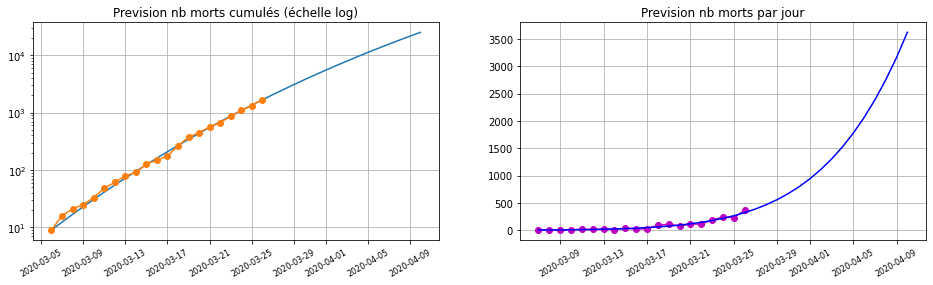

In [0]:
print(param)
date1 = datetime.date(2020, 2, 25)
disp_fit(param, m, 15, start = start, date1 = date1)

## Modèle bayésien

## Le 25 Mars

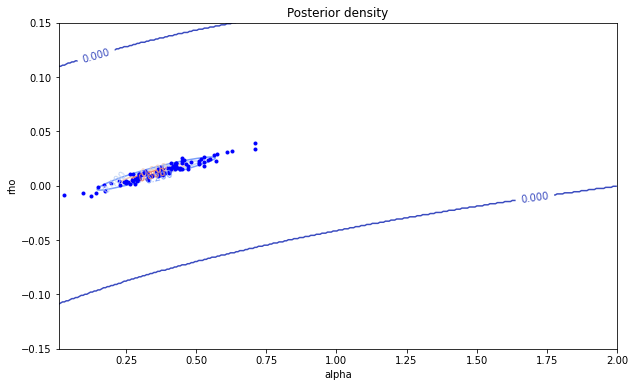

alpha0 = 0.34
rho    = 0.01


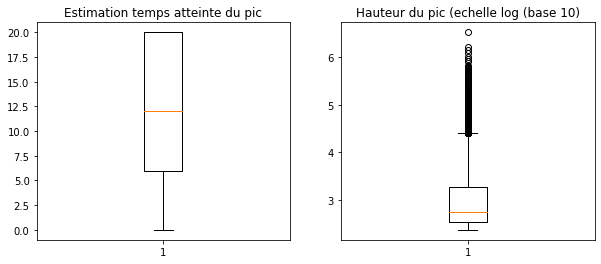

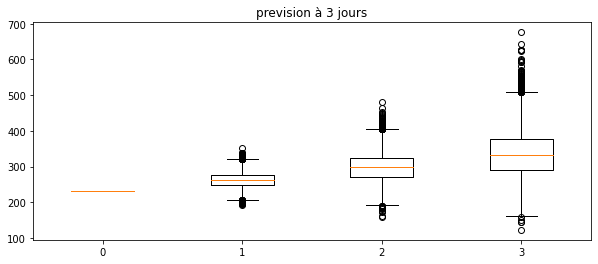

In [0]:
mj = np.array([15,13,18,12,36, 21, 27, 89, 108, 78, 112, 112, 186, 240, 231])
start = len(mj)-1
M, n_hor = 10000, 20
sampler = par_estim(mj,start)
bayes_pred(sampler, mj[start], start, M, n_hor)

## Corée du sud
C'est un cas très spécial de réussite (jusqu'à présent) de contrôle de l'épidémie avec un nombre de m/j qui est resté très faible. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 6 8 10 12
 13 13 16 17 28 28 35 35 42 44 50 53 54 60 66 66 72 75 75 81 84 91 94 102
 104]


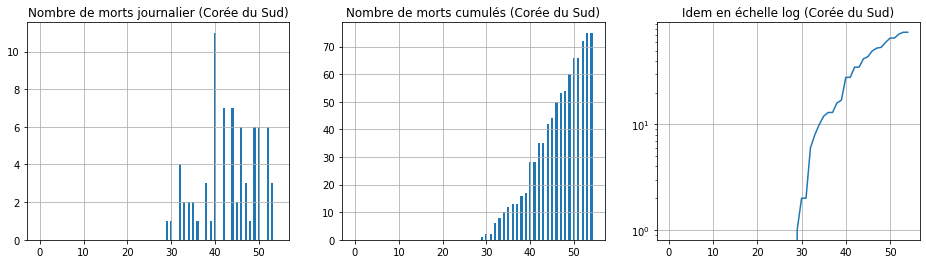

In [0]:
korea = load_csse("Korea, South")
korea.head()
m = korea.iloc[0,4::].to_numpy()
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]
mj= mj[0:-6]
show_data(mj,"Corée du Sud")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


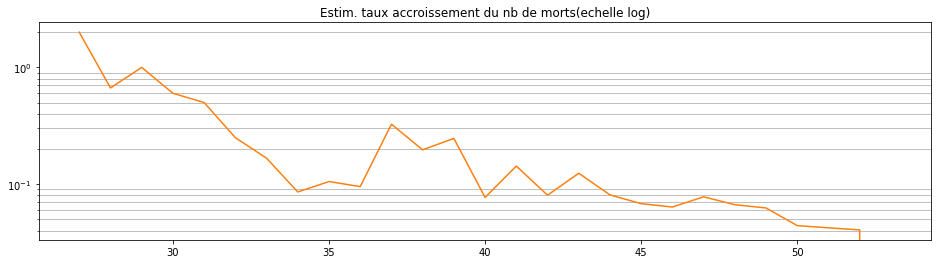

rho estimé nan


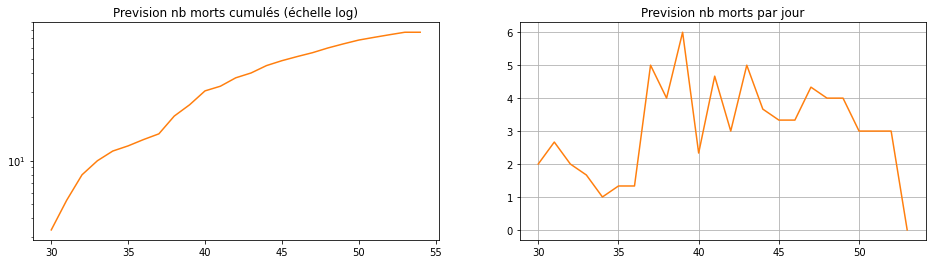

In [0]:
rmj = np.zeros(np.shape(mj))
rmj = mj
rmj[0:-2]= (mj[0:-2]+mj[1:-1]+mj[2::])/3
reg = fit_slope(rmj, start = 30)
predic(rmj, reg, start = 30, end = 90)

# Iran

Les données iraniennes ne semblent pas fiables. Notamment les fluctuation dans le nombre de morts attendu dans un modèle poissionnien n'apparaissent pas. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 5 8 12 16
 19 26 34 43 54 66 77 92 107 124 145 194 237 291 354 429 514 611 724 853
 988 1135 1284 1433 1556 1685 1812 1934 2077]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


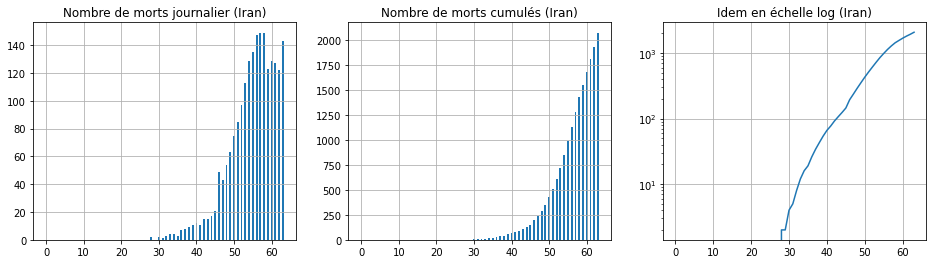

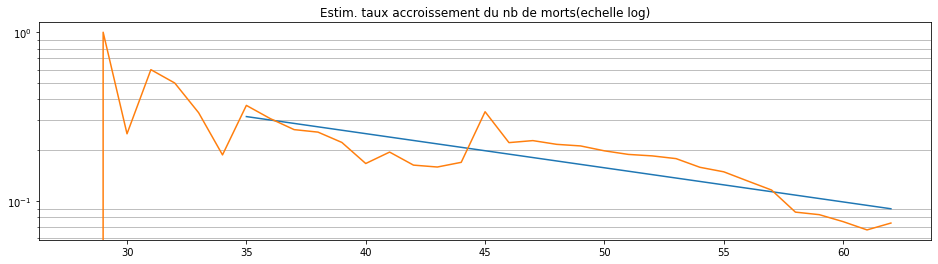

rho estimé 0.04660429680659795


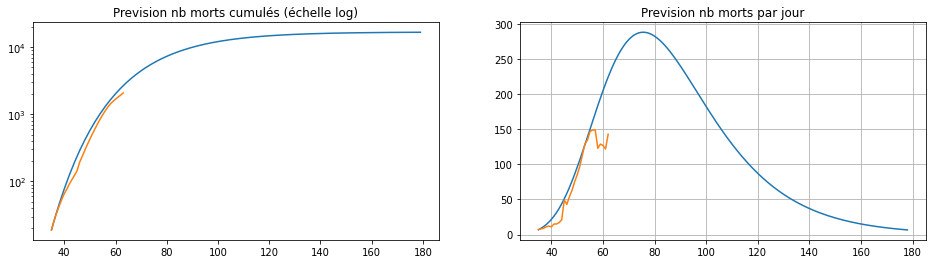

In [0]:
StateName = "Iran"
state = load_csse(StateName)
state.head()
m = state.iloc[0,4::].to_numpy()
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]
show_data(mj,StateName)
reg = fit_slope(mj, start = 35)
predic(mj, reg, start = 35, end = 180)

# Allemagne


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 3 3 7 9 11 17 24 28 44 67 84 94 123 157 206]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


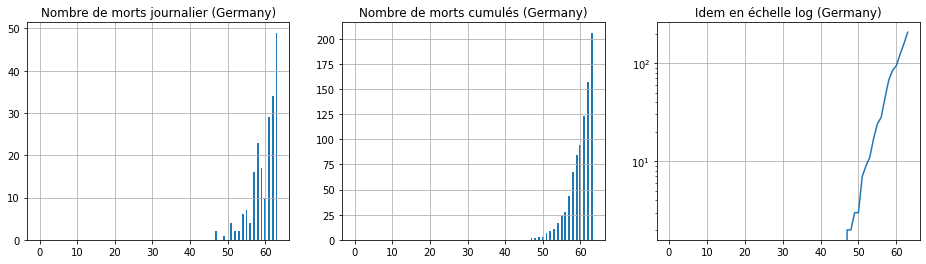

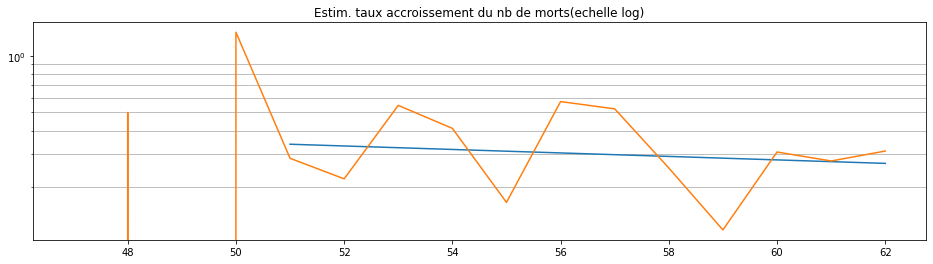

rho estimé 0.021279473690885963
performing optimization...
Optimization (L-BFGS) time:  16.63  seconds


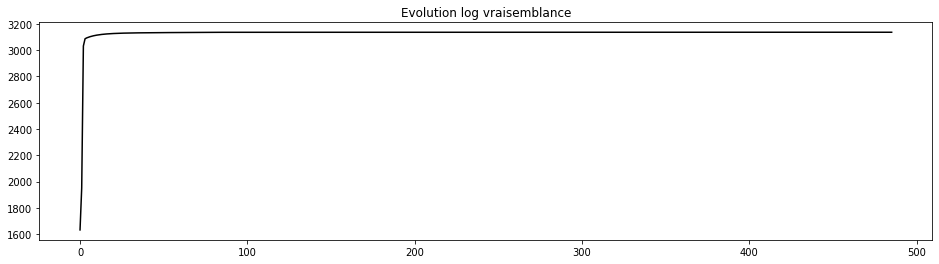

tensor([5.9564, 0.3839, 0.0470], requires_grad=True)
43


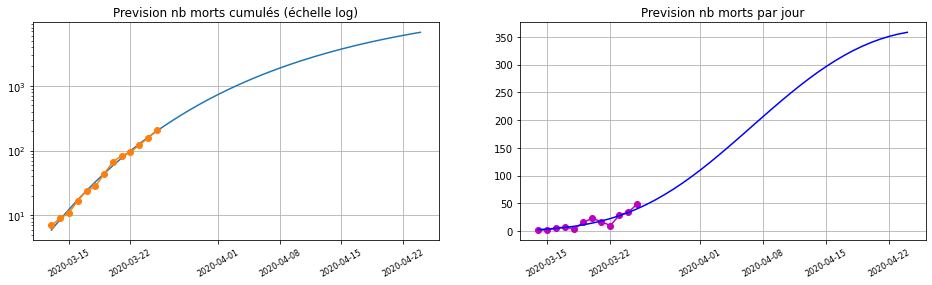

In [0]:
StateName = "Germany"
state = load_csse(StateName)
state.head()
m = state.iloc[0,4::].to_numpy()
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]
start = 51
show_data(mj,StateName)
m = np.cumsum(mj)
reg = fit_slope(mj, start = start)
param_init = [m[start], reg[1], -reg[0]]
param = fit_zombie(m[start::], param_init = param_init, niter = 100, verbose = False)
print(param)
date1 = datetime.date(2020, 1, 22)
disp_fit(param, m, 30, start = start, date1 = date1)

# Espagne

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 2 3 5 10 17 28 35 54 55 133 195 289 342 533 623 830 1043 1375
 1772 2311 2808 3647]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


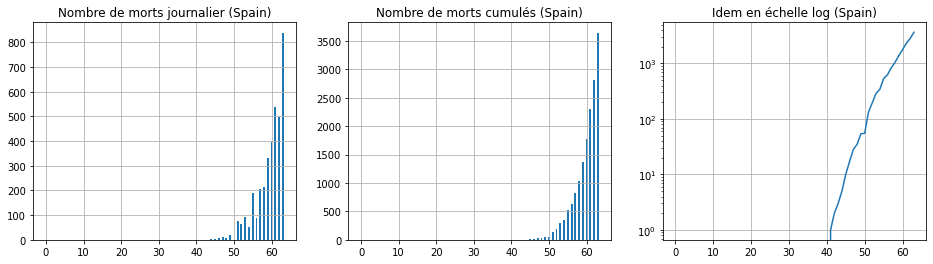

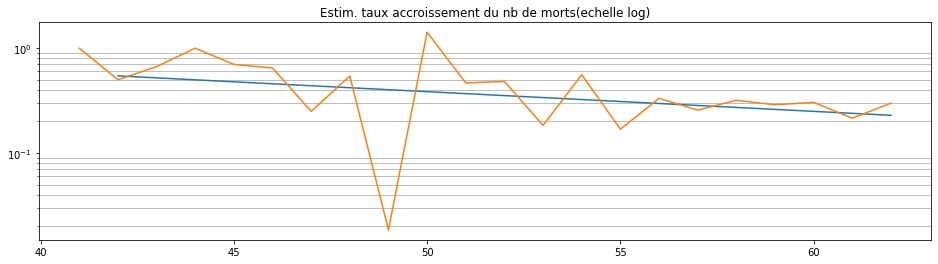

rho estimé 0.04325547536608926
performing optimization...
Optimization (L-BFGS) time:  29.54  seconds


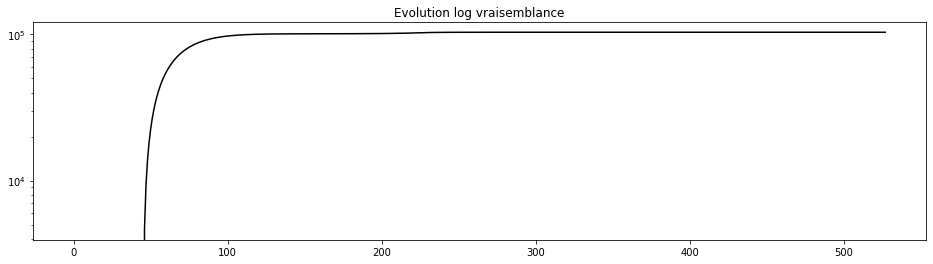

In [0]:
StateName = "Spain"
state = load_csse(StateName)
state.head()
m = state.iloc[0,4::].to_numpy()
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]
show_data(mj,StateName)
start = 42
m = np.cumsum(mj)
reg = fit_slope(mj, start = start)
param_init = [m[start], reg[1], -reg[0]]
param = fit_zombie(m[start::], param_init = param_init, niter = 100, verbose = False)

tensor([1.9018, 0.5705, 0.0482], requires_grad=True)
42


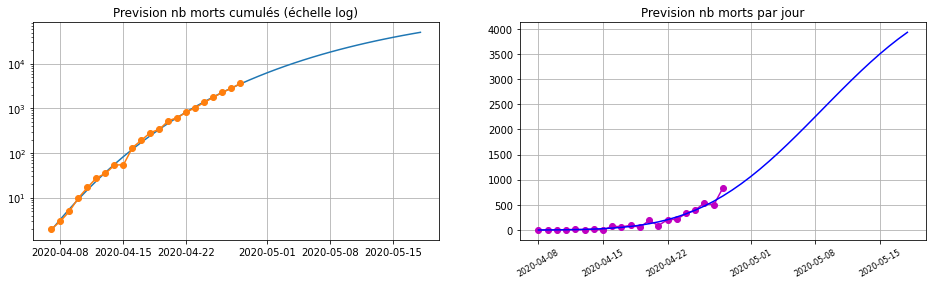

In [0]:
print(param)
date1 = datetime.date(2020, 2, 25)
disp_fit(param, m, 20, start = start, date1 = date1)

# USA

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1   1   6   7  11  12  14  17  21  22  28  36  40  47  54  63
  85 108 118 200 244 307 417 557 706 942]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


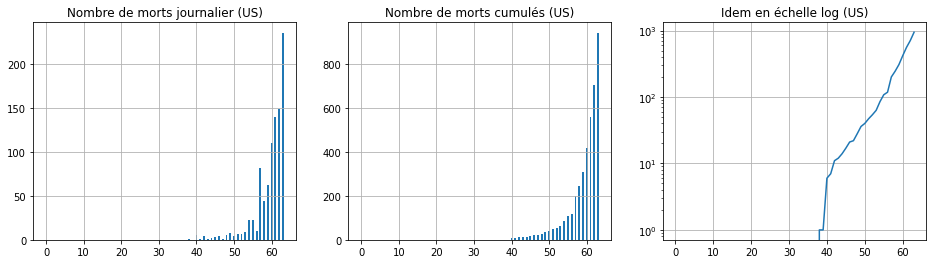

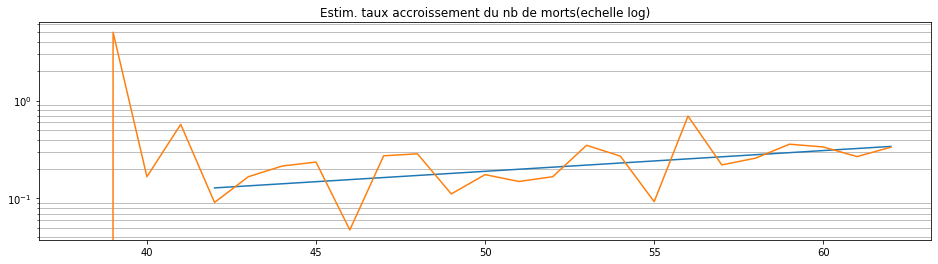

rho estimé -0.048851895657686814
performing optimization...
Optimization (L-BFGS) time:  60.37  seconds


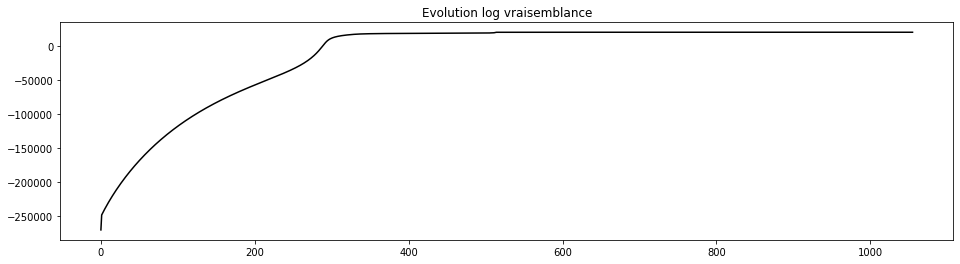

In [0]:
StateName = "US"
state = load_csse(StateName)
state.head()
m = np.sum(state.iloc[:,4::].to_numpy(),axis = 0)
print(m)
nb_j = np.shape(m)[0] # nb de données
mj = np.zeros(nb_j)
mj[0]=m[0]
mj[1::]=m[1::] - m[0:-1]
show_data(mj,StateName)
start = 42
m = np.cumsum(mj)
reg = fit_slope(mj, start = start)
param_init = [m[start], reg[1], 0.]
param = fit_zombie(m[start::], param_init = param_init, lr = 0.01, 
                   niter = 100)

tensor([11.1395,  0.1365, -0.0395], requires_grad=True)
29


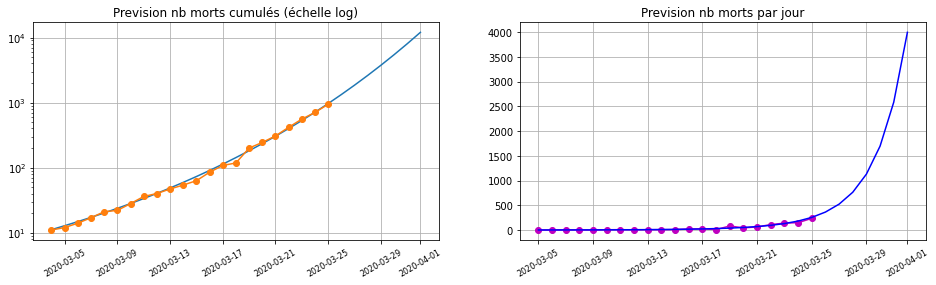

In [0]:
print(param)
date1 = datetime.date(2020, 1, 22)
disp_fit(param, m, 7, start = start, date1 = date1)

# Modèle Zombie sur cas confirnés

## France

### Modèle déterministe

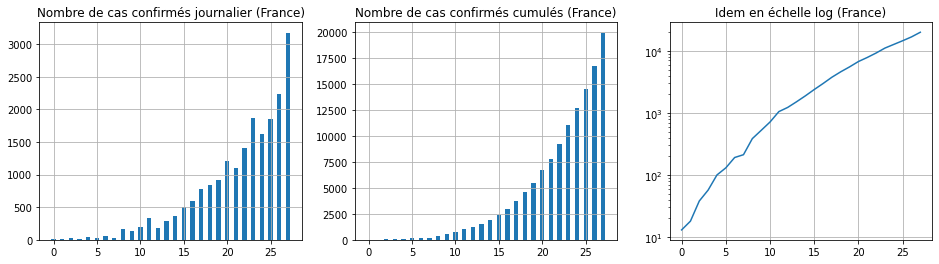

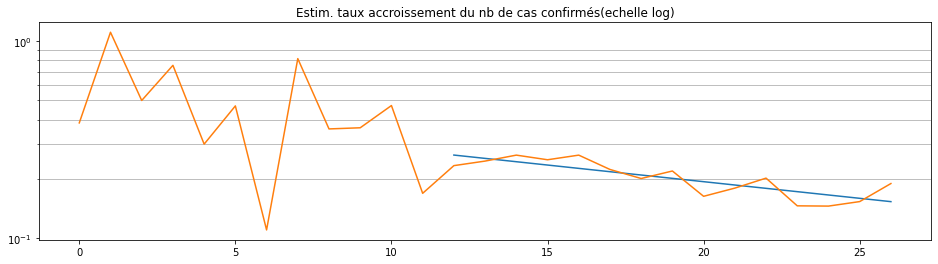

rho estimé 0.03893549027857142


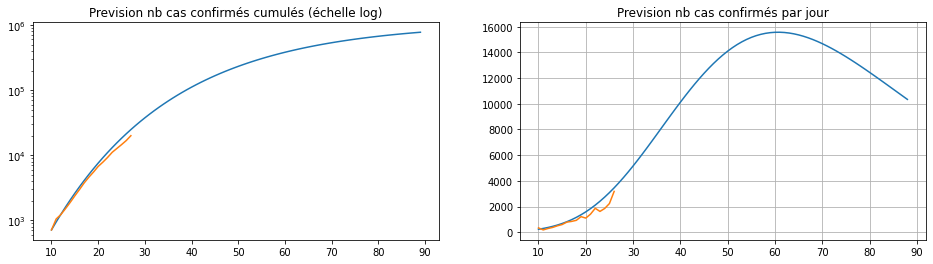

In [0]:
# Cas confirmés journaliers du covid19 France
label = 'cas confirmés'
mj = np.array([13, 5, 20, 19, 43, 30, 61, 21, 173, 138, 190, 336, 177, 286, 372, 497, 595, 785, 839, 923,1210, 1097, 1404, 1861, 1617, 1847, 2230, 3176])
show_data(mj,'France', label = label)
reg = fit_slope(mj, start = 12, label = label)
predic(mj, reg, start = 10, end = 90, label = label)

### Modèle Poissonien

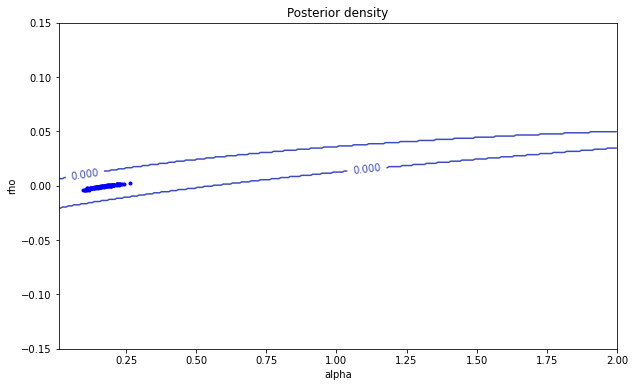

alpha0 = 0.18
rho    = -0.00


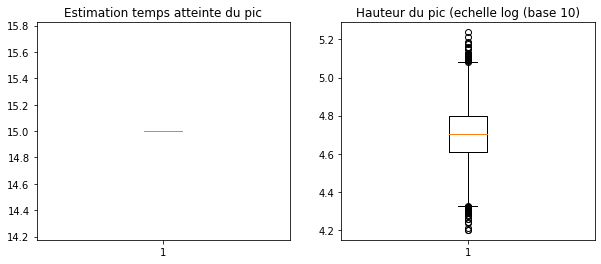

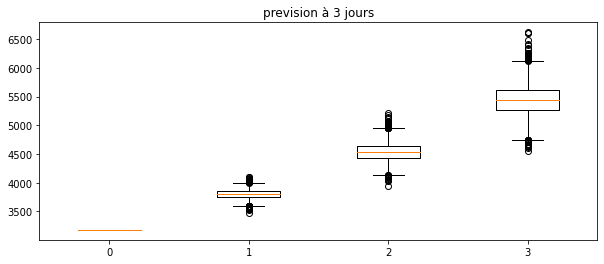

3176


In [0]:
mj = np.array([13, 5, 20, 19, 43, 30, 61, 21, 173, 138, 190, 336, 177, 286, 372, 497, 595, 785, 839, 923,1210, 1097, 1404, 1861, 1617, 1847, 2230, 3176])
start = len(mj)-1
M, n_hor = 10000, 15
sampler = par_estim(mj,start)
bayes_pred(sampler, mj[start], start, M, n_hor)
print(mj[start])

## Italie

### Modèle deterministe

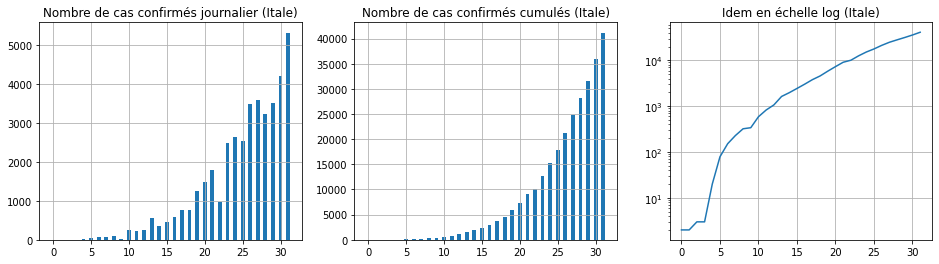

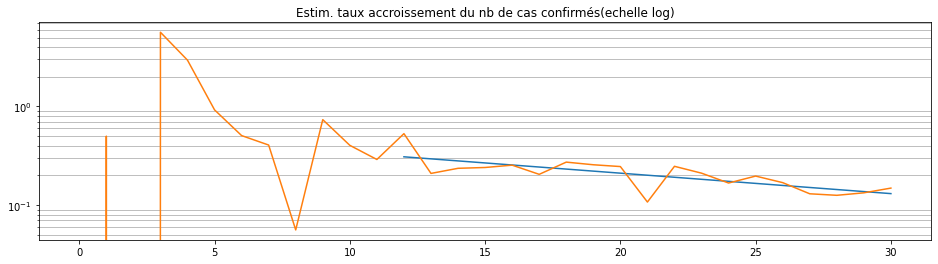

rho estimé 0.04777800650909718


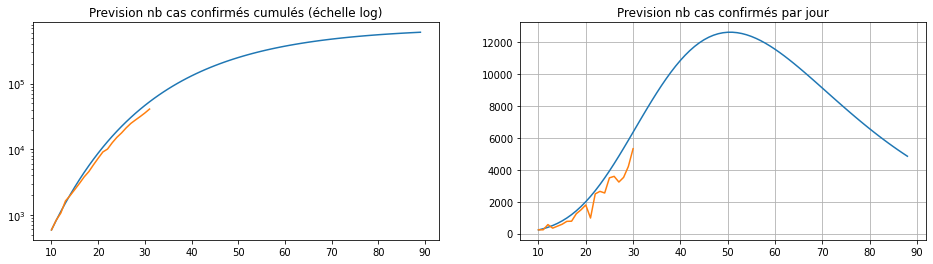

In [0]:
# Cas confirmés journaliers du covid19 Italie
label = 'cas confirmés'
mj = np.array([2, 0, 1, 0, 17, 59, 73, 77, 93, 18, 250, 238, 240, 566, 342, 466, 587, 769, 778, 1247, 1492, 1797, 977, 2493, 2649, 2547, 3497, 3590, 3233, 3526, 4207, 5322])
show_data(mj,'Itale', label = label)
reg = fit_slope(mj, start = 12, label = label)
predic(mj, reg, start = 10, end = 90, label = label)

### Modèle Poissonnien

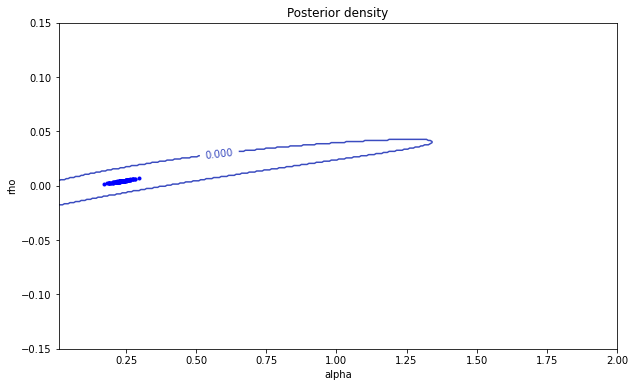

alpha0 = 0.24
rho    = 0.00


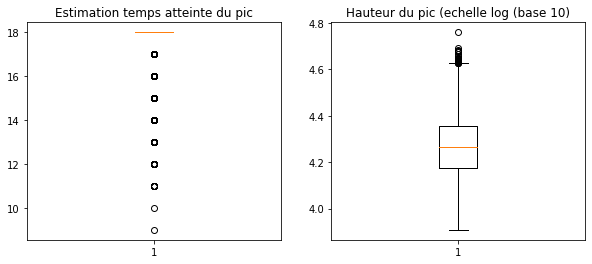

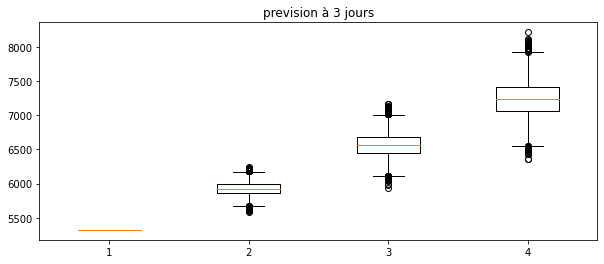

5322


In [0]:
mj = np.array([93, 18, 250, 238,240, 566, 342, 466, 587, 769, 778, 1247, 1492, 1797, 977, 2493, 2649, 2547, 3497, 3590, 3233, 3526, 4207, 5322])
start = len(mj)-1
M, n_hor = 10000, 18
sampler = par_estim(mj,start)
bayes_pred(sampler, mj[start], start, M, n_hor)
print(mj[start])